# Transfer learning - Fine-tuning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Might train more than 1-3 layers

<img src='https://camo.githubusercontent.com/a30cd9d1a1f7b27a2d429dddb2a436ba4e6fd12df16b6623f3385cac6fba333b/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d7472616e736665722d6c6561726e696e672d666561747572652d65787472616374696f6e2d76732d66696e652d74756e696e672e706e67' />

### Data exploration

In [1]:
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [2]:
walk_through_dir('data/10_food_classes_10_percent')

There are 2 directories and 0 images in 'data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\steak'.
There are 0 di

In [3]:
train_dir = 'data/10_food_classes_10_percent/train/'
test_dir = 'data/10_food_classes_10_percent/test/'

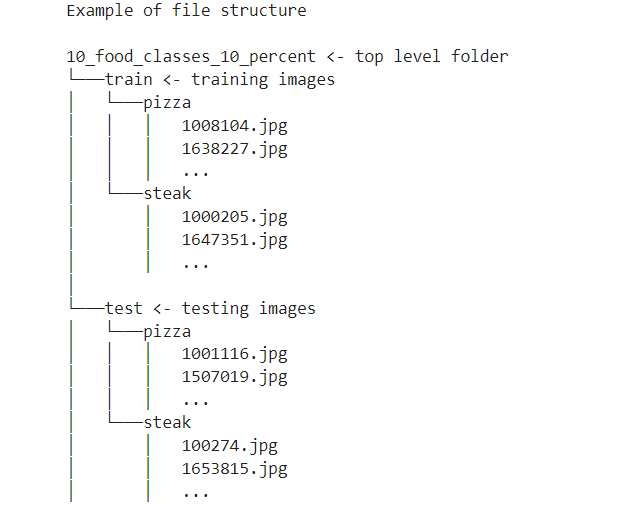

Below the `tf.keras.preprocessing.image_dataset_from_directory()` approach is used rather than the `ImageDataGenerator`. There is pretty much no difference between them, except for the object created. This approach created a `tf.data.Dataset` object rather than a generator, which is much more efficient, while the generator is performs better for larger datasets

The parameters accepted are pretty much the same too.

In [4]:
# Create data inputs
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    # Default batch size
    batch_size=32,
    # Type of labels (outputs)
    label_mode='categorical'
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

`(None, 224, 224, 3)` refer to the tensor shape of the images. `None` being the batch size, `224` being the width and height & `3` being the number of channels

`(None, 10)` refers to the tensor shape of the labels, where `10` is the number of classes

**Side-note** The batch size is always None since it is just a placeholder until its used during model training, where the `image_dataset_from_directory()` would then fill. Until then (The model is trained) it remains as None

In [6]:
# Further inspection shows more advantages
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# Take the first batch
for images, labels in train_data.take(1):
    print(images.shape, images, labels)

(32, 224, 224, 3) tf.Tensor(
[[[[5.33571434e+01 4.13571434e+01 2.73571434e+01]
   [5.10714264e+01 3.90714264e+01 2.50714283e+01]
   [4.57857132e+01 3.67857132e+01 2.17857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[5.38651161e+01 4.18651161e+01 2.78651142e+01]
   [5.11278687e+01 3.91278687e+01 2.51278687e+01]
   [4.57857132e+01 3.67857132e+01 2.17857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[5.45609055e+01 4.25609055e+01 2.85609055e+01]
   [5.20940666e+01 4.00940666e+01 2.60940685e+01]
   [4.67857132e+01 3.77857132e+01 2.27857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  ...

  [[1.68274841e+01 3.18462682e+00 0.0

### Build model with Functional API

The Keras functional API also have models that were pretrained (on ImageNet)

In [12]:
# Create feature extraction efficientnet model
base_model = tf.keras.applications.EfficientNetB0(
    # Will add our own top (output) layer
    include_top=False
)

# Freeze base model
base_model.trainable = False

# Create inputs for base model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='input_layer')

# Normalize input  (Required for Resnet, not for efficientnet: this is built in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# Pass inputs to base model
x = base_model(inputs)
print(f'Shape after base_model: {x.shape}')

# Add average pooling - transforms 4D tensor to 2D, by averaging values across the inner-axes
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# Create output layer
outputs = tf.keras.layers.Dense(10, activation='linear', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_0 = model_0.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    # Validate for less data so training is faster
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback('tensorboard_logs_1', 'efficientnetB0')]
    
)

Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorboard_logs_1/efficientnetB0/20220924-055718
Epoch 1/5
24/24 [==============================] - 89s 3s/step - loss: 1.8699 - accuracy: 0.4560 - val_loss: 1.2970 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 75s 3s/step - loss: 1.0921 - accuracy: 0.7680 - val_loss: 0.8679 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 71s 3s/step - loss: 0.7741 - accuracy: 0.8320 - val_loss: 0.6644 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 75s 3s/step - loss: 0.6264 - accuracy: 0.8587 - val_loss: 0.6030 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 78s 3s/step - loss: 0.5357 - accuracy: 0.8880 - val_loss: 0.5408 - val_accuracy: 0.8651


The `GlobalAveragePooling2D` layer pools the outputs into a shape that is compatible with the outputs (same shape as the labels). `GlobalMaxPooling2D` can also be used, however the former is more common in practice.

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
model_0.evaluate(test_data)

79/79 [==============================] - 130s 2s/step - loss: 0.5491 - accuracy: 0.8612


[0.5491406917572021, 0.8611999750137329]

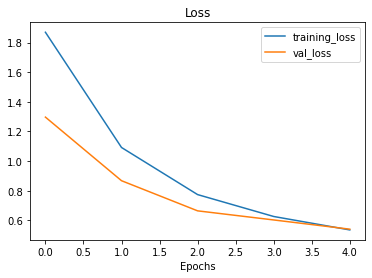

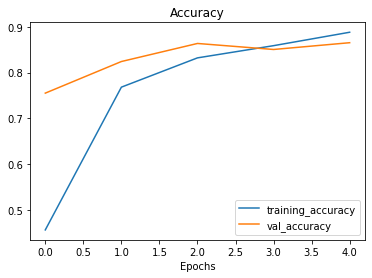

In [15]:
plot_loss_curves(history_0)

### Getting a feature vector from a trained model

Demo what the `GlobalAveragePooling2D` layer does

In [29]:
# Similar 4D tensor
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')
print(input_tensor.shape)

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

(1, 4, 4, 3)


In [27]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')
print(global_average_pooled_tensor.shape)

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

(1, 3)


It effectively averages the data across the middle two axes (4, 4). Additionally, therefore, creates the required shape (1D vector **feature vector**) for the Dense layer by condensing the information.

A Feature vector is a learned representation of the input data (a compressed form of the input based on how the model see's it)
 * The output of a the pretrained model is the feature vector - which is sent to our output layer

**Side-Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in this case, it is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of.

In [30]:
# Replicate averaging across middle two axes
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

Demo what the `GlobalMaxPooling2D` layer does

In [31]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f'2D global max pooled random tensor:\n {global_max_pooled_tensor}\n')
print(global_max_pooled_tensor.shape)

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

(1, 3)


In [39]:
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

### Running a series of experiments

* `model_1` Use feature extraction on 1% of data with data augmentation
* `model_2` Use feature extraction on 10% of data with data augmentation
* `model_3` Use fine tuning on 10% of data with data augmentation
* `model_4` Use fine tuning on 100% of data with data augmentation

Test all on the same test dataset

In [20]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LABEL_MODE = 'categorical'

In [16]:
# Download and unzip data
!curl -O https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  127M    0  3871    0     0   2801      0 13:15:01  0:00:01 13:15:00  2805
  0  127M    0  943k    0     0   515k      0  0:04:12  0:00:01  0:04:11  516k
  2  127M    2 3518k    0     0  1245k      0  0:01:44  0:00:02  0:01:42 1245k
  5  127M    5 6590k    0     0  1722k      0  0:01:15  0:00:03  0:01:12 1723k
  7  127M    7 9870k    0     0  2041k      0  0:01:03  0:00:04  0:00:59 2041k
  9  127M    9 12.1M    0     0  2139k      0  0:01:00  0:00:05  0:00:55 2802k
 11  127M   11 15.0M    0     0  2258k      0  0:00:57  0:00:06  0:00:51 2895k
 14  127M   14 17.9M    0     0  2334k      0  0:00:55  0:00:07  0:00:48 2944k
 16  127M   16 20.5M    0     0  2385k      0  0:00:54  0:00:08  0:00:46 2893k
 18  127M   18 23.5M    0     0  2454k      0  0:00

In [17]:
train_dir_1_percent = 'data/10_food_classes_1_percent/train/'
test_dir = 'data/10_food_classes_1_percent/test/'

In [18]:
walk_through_dir('data/10_food_classes_1_percent')

There are 2 directories and 0 images in 'data/10_food_classes_1_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_1_percent\test'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\steak'.
There are 0 directories a

In [21]:
# Setup data loaders

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode=LABEL_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation into model

Since the `image_dataset_from_directory` doesn't augment data like `ImageDataGenerator` a separate layer can be added into the model itself. The benefits of this are:
* The augmentation happens on GPU than CPU (`ImageDataGenerator` utilizes CPU). Images are best preprocessed on GPU while text & structured data are more suited for CPU
* Augmentation occurs only during training, so the whole model can be exported and used elsewhere. Futhermore, someone else could train the same model, including the same data augmentation

<img src='https://camo.githubusercontent.com/522ed250e865b937a1d3ed0dca629ed12019bf6c155f444331eb1eba08c6b9dc/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d646174612d6175676d656e746174696f6e2d696e736964652d612d6d6f64656c2e706e67' />

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [23]:
# This sequential model can be fit as a layer to the transfer learning model
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.), # Not required for efficientnet
], name='data_augmentation')

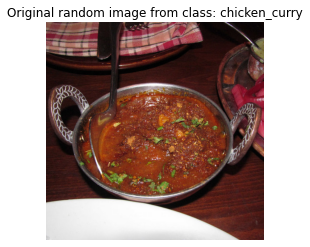

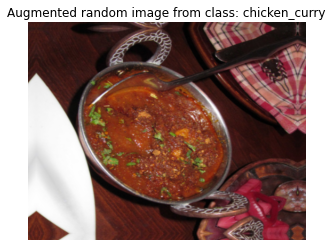

In [31]:
# Visualize data augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = 'data/10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# data augmentation model requires shape (None, height, width, 3): Original - (height, width, 3)
# set training=True (to be explicit) since augmentation occurs only during model training
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
